In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("kidiq.csv", sep=";")

Data description

```
kid_score Child's IQ score
        mom_hs Indicator for whether the mother has a high school degree
        mom_iq Mother's IQ score
        mom_work 1 = did not work in first three years of child's life
                 2 = worked in 2nd or 3rd year of child's life
                 3 = worked part-time in first year of child's life
                 4 = worked full-time in first year of child's life
        mom_age Mother's age

```


In [5]:
df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1,121.117529,4,27
1,98,1,89.361882,4,25
2,85,1,115.443165,4,27
3,83,1,99.449639,3,25
4,115,1,92.745710,4,27


In [6]:
df.corr()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
kid_score,1.000000,0.236916,0.448276,0.087528,0.091998
mom_hs,0.236916,1.000000,0.282709,0.253910,0.214528
mom_iq,0.448276,0.282709,1.000000,0.114803,0.091608
mom_work,0.087528,0.253910,0.114803,1.000000,0.135598
mom_age,0.091998,0.214528,0.091608,0.135598,1.000000


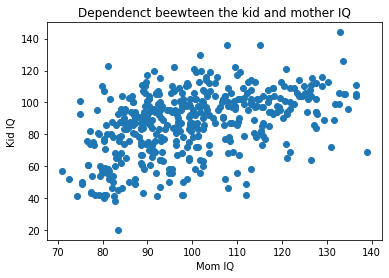

In [14]:
plt.scatter(df.mom_iq.values, df.kid_score.values)
plt.title("Dependenct beewteen the kid and mother IQ")
plt.ylabel("Kid IQ")
plt.xlabel("Mom IQ")
plt.show()

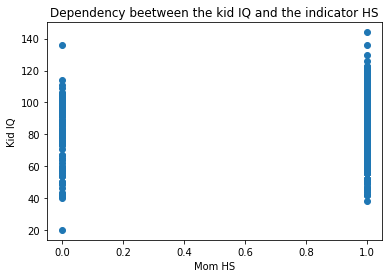

In [16]:
plt.scatter( df.mom_hs.values, df.kid_score.values)
plt.title('Dependency beetween the kid IQ and the indicator HS')
plt.ylabel("Kid IQ")
plt.xlabel("Mom HS")
plt.show()

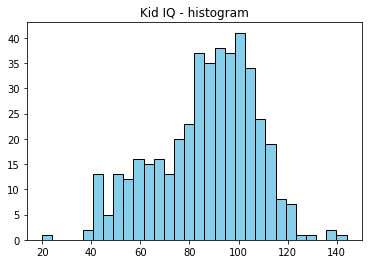

In [19]:
plt.hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
plt.title('Kid IQ - histogram')
plt.show()

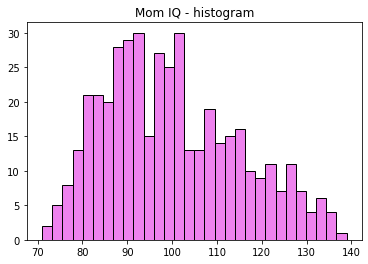

In [21]:
plt.hist(df.mom_iq.values, bins=30, color='violet', edgecolor='black')
plt.title('Mom IQ - histogram')
plt.show()

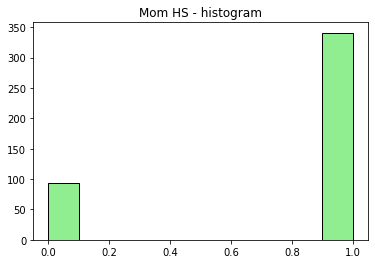

In [26]:
plt.hist(df.mom_hs.values, color='lightgreen', edgecolor='black')
plt.title('Mom HS - histogram')
plt.show()

In [31]:
from cmdstanpy import CmdStanModel
R = 1000
model_1=CmdStanModel(stan_file='prior1.stan')

model_1_samp = model_1.sample(data = {'N': df.shape[0], 'mom_iq': df["mom_iq"].values},
                     iter_sampling=R,
                     iter_warmup=1,
                     chains=1,
                     fixed_param=True,
                     seed=2904)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


INFO:cmdstanpy:CmdStan done processing.


In [32]:
print(model_1_samp.stan_variable("beta0"))

[  0.       0.     102.879    0.       0.       0.       0.     102.093
 134.227  136.911  118.57     0.       0.       0.     113.12   126.01
   0.       0.     103.633  123.212  102.702    0.       0.       0.
   0.       0.     133.786    0.       0.      75.7451   0.     106.029
   0.       0.       0.       0.       0.     112.759  131.176   68.8875
   0.       0.     104.642    0.       0.      96.2332 123.425  122.95
   0.     132.136   96.9017   0.       0.     130.151    0.       0.
   0.     134.057    0.     122.506   89.34   146.165  103.471   82.4419
   0.       0.       0.     145.443    0.     106.692   76.1658   0.
 110.748  103.792  125.559    0.     108.826    0.     123.226    0.
 144.213  106.329    0.       0.     125.275    0.       0.       0.
 113.469   98.9693   0.       0.       0.     144.674  107.941    0.
   0.       0.     130.661    0.     135.701    0.     164.37     0.
   0.       0.     133.934  141.586  108.783    0.     104.736   83.9483
   0.       

In [33]:
print(model_1_samp.stan_variable("beta1"))

[ 0.00000e+00  0.00000e+00  8.57930e-01  0.00000e+00  0.00000e+00
  0.00000e+00  0.00000e+00 -5.30723e-01  1.69661e+00 -5.68106e-01
 -2.07120e+00  0.00000e+00  0.00000e+00  0.00000e+00  8.80730e-02
 -2.80751e-01  0.00000e+00  0.00000e+00  7.13798e-02 -2.78177e-01
 -5.66283e-01  0.00000e+00  0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00 -1.85139e-01  0.00000e+00  0.00000e+00 -1.09026e+00
  0.00000e+00 -7.12449e-01  0.00000e+00  0.00000e+00  0.00000e+00
  0.00000e+00  0.00000e+00  6.05507e-01  8.14451e-01 -1.86461e+00
  0.00000e+00  0.00000e+00 -5.07310e-01  0.00000e+00  0.00000e+00
  2.73522e-01 -2.74315e+00  1.62902e+00  0.00000e+00  9.08001e-01
  1.37608e+00  0.00000e+00  0.00000e+00  5.42500e-01  0.00000e+00
  0.00000e+00  0.00000e+00 -3.72812e-01  0.00000e+00  6.41863e-01
 -1.61386e+00 -5.67898e-01 -2.04494e+00 -1.46871e+00  0.00000e+00
  0.00000e+00  0.00000e+00 -1.85158e+00  0.00000e+00  8.24123e-01
  8.36523e-01  0.00000e+00  1.27800e-02  7.61991e-01 -7.69558e-01
  0.00000e

In [34]:
yields_pred_prior = model_1_samp.stan_variable("kid_score")
yields_pred_prior_means = np.mean(yields_pred_prior, axis=0)

In [35]:
print(model_1_samp.stan_variable("sigma"))

[0.00000e+00 0.00000e+00 1.53942e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 7.74580e-01 1.40539e-01 3.79922e-01 7.81440e+01 0.00000e+00
 0.00000e+00 0.00000e+00 5.94820e+00 1.11395e+01 0.00000e+00 0.00000e+00
 7.85096e+00 1.68741e+00 3.38524e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 0.00000e+00 5.26256e-02 0.00000e+00 0.00000e+00 1.28830e-01
 0.00000e+00 1.96958e+01 0.00000e+00 0.00000e+00 0.00000e+00 0.00000e+00
 0.00000e+00 7.68830e+00 5.72786e+00 1.09020e+02 0.00000e+00 0.00000e+00
 1.92325e+00 0.00000e+00 0.00000e+00 9.14675e+01 4.60175e+01 6.70629e+00
 0.00000e+00 1.64285e+00 1.18403e+01 0.00000e+00 0.00000e+00 2.82254e+01
 0.00000e+00 0.00000e+00 0.00000e+00 8.24737e+00 0.00000e+00 1.10115e+00
 8.38582e+00 1.45914e+02 3.55717e+00 6.62430e+00 0.00000e+00 0.00000e+00
 0.00000e+00 4.50125e+00 0.00000e+00 1.19392e+01 9.21376e+00 0.00000e+00
 2.74427e+00 3.73622e+00 3.40702e+00 0.00000e+00 1.75565e+01 0.00000e+00
 1.20945e+01 0.00000e+00 9.62298e-02 1.17942e+01 0.

In [36]:
print(yields_pred_prior_means)

[58.96824792 51.12309391 60.36644964 57.4602891  53.98995251 54.99223764
 57.54913569 54.82238408 58.04373301 58.636497   53.75803102 61.93182626
 48.36044928 51.29878378 53.82884068 62.20808787 49.93701578 51.47512043
 53.6696773  53.77950155 49.23047254 55.39163793 58.94932323 58.81236715
 56.55541167 55.45632639 56.45888417 54.51706518 55.77027184 57.27707798
 57.88025891 51.90711284 59.04731326 59.29287524 48.89090323 68.87712329
 53.36005329 51.36339372 68.59330255 53.34583068 44.94962688 52.66260116
 46.21033734 53.88094662 57.71912403 59.14259375 57.01844967 56.56832167
 51.9145554  61.82178034 54.94766636 52.55336132 53.14290572 57.706958
 51.51611974 52.2096317  60.78360623 55.38904289 55.18791264 56.48327651
 55.12690613 63.91337179 58.15509268 53.49887475 63.36690129 64.64710421
 60.03350652 49.8475351  51.57577926 60.28869136 57.77325027 55.26049019
 61.00864152 49.57111801 62.20421884 65.61066489 54.36362296 58.02231809
 56.67192011 52.6318646  54.84288064 54.18845548 51.0

In [37]:
print(model_1_samp.summary())

                   Mean   MCSE  StdDev    5%  50%    95%   N_Eff  N_Eff/s  \
name                                                                        
lp__             0.0000    NaN    0.00   0.0  0.0    0.0     NaN      NaN   
beta0           55.0000  1.900   57.00   0.0  0.0  140.0   960.0   4500.0   
beta1           -0.0021  0.025    0.72  -1.4  0.0    1.2   810.0   3800.0   
sigma           12.0000  4.200  130.00   0.0  0.0   32.0  1000.0   4800.0   
kid_score[1]    59.0000  4.300  134.00 -62.0  0.0  272.0   991.0   4674.0   
...                 ...    ...     ...   ...  ...    ...     ...      ...   
kid_score[430]  52.0000  3.700  117.00 -17.0  0.0  227.0   981.0   4627.0   
kid_score[431]  55.0000  3.000   95.00 -27.0  0.0  232.0  1007.0   4749.0   
kid_score[432]  55.0000  3.000   92.00 -26.0  0.0  236.0   931.0   4392.0   
kid_score[433]  57.0000  3.400  106.00 -30.0  0.0  245.0   963.0   4542.0   
kid_score[434]  58.0000  4.400  136.00 -17.0  0.0  233.0   969.0   4572.0   

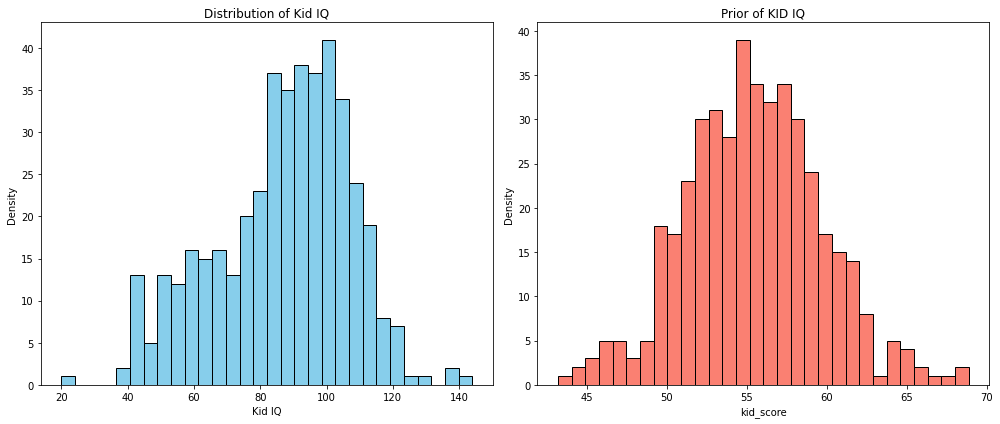

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(yields_pred_prior_means, bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

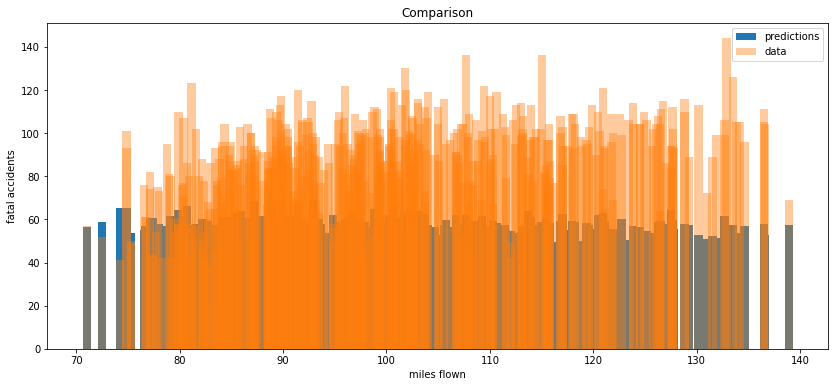

In [41]:
plt.figure(figsize=(14,6))
plt.bar(df.mom_iq.values,yields_pred_prior_means, label="predictions")
plt.bar(df.mom_iq.values,df.kid_score.values, label="data", alpha =0.4)
plt.title("Comparison")
plt.ylabel("fatal accidents")
plt.xlabel("miles flown")
plt.legend()
plt.show()

In [42]:
print(df["kid_score"].values)

[ 65  98  85  83 115  98  69 106 102  95  91  58  84  78 102 110 102  99
 105 101 102 115 100  87  99  96  72  78  77  98  69 130 109 106  92 100
 107  86  90 110 107 113  65 102 103 111  42 100  67  92 100 110  56 107
  97  56  95  78  76  86  79  81  79  79  56  52  63  80  87  88  92 100
  94 117 102 107  99  73  56  78  94 110 109  86  92  91 123 102 105 114
  96  66 104 108  84  83  83  92 109  95  93 114 106  87  65  95  61  73
 112 113  49 105 122  96  97  94 117 136  85 116 106  99  94  89 119 112
 104  92  86  69  45  57  94 104  89 144  52 102 106  98  97  94 111 100
 105  90  98 121 106 121 102  64  99  81  69  84 104 104 107  88  67 103
  94 109  94  98 102 104 114  87 102  77 109  94  93  86  97  97  88 103
  87  87  90  65 111 109  87  58  87 113  64  78  97  95  75  91  99 108
  95 100  85  97 108  90 100  82  94  95 119  98 100 112 136 122 126 116
  98  94  93  90  70 110 104  83  99  81 104 109 113  95  74  81  89  93
 102  95  85  97  92  78 104 120  83 105  68 104  8

In [43]:
R = 1000
model=CmdStanModel(stan_file='model1.stan')

model_1_fit = model.sample(data = {'N': df.shape[0], 'mom_iq': df["mom_iq"].values, 'kid_score': df["kid_score"].values},
                     iter_sampling=R,
                     chains=1)

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:01 Sampling completed                       


INFO:cmdstanpy:CmdStan done processing.


In [48]:
yields_pred = model_1_fit.stan_variable("kid_score_pred")
yields_pred_means = np.mean(yields_pred, axis=0)
print(yields_pred_prior)

[[ 85.6786  88.6917  52.1375 ...  84.7274  90.1933  79.317 ]
 [133.202   51.5015 104.6    ... 101.504   78.436   94.1594]
 [ 88.5093  94.5889 100.828  ... 103.937   71.8284  89.4443]
 ...
 [105.206   75.1645 116.199  ...  74.9762 104.957   96.914 ]
 [ 85.2867  97.637   88.9908 ... 110.393   65.558   86.2141]
 [ 92.6389  57.7377  95.74   ... 121.162   92.5953  88.6543]]


In [45]:
print(model_1_fit.stan_variable("beta0"))

[35.3422 36.4048 31.1117 34.5511 32.7294 31.6235 31.4496 32.4704 32.7323
 29.3777 33.9458 34.3458 34.3341 36.3316 40.11   40.3303 40.378  26.0043
 27.3269 27.2791 27.4737 38.2082 32.3967 30.7034 29.8236 37.3946 36.4215
 34.2595 31.2042 24.509  24.8921 24.9775 29.3663 33.8019 35.106  31.604
 33.3759 33.7374 37.0731 31.0421 31.0183 31.4167 36.399  29.9528 30.3809
 29.4092 31.5078 32.7964 31.4215 35.7961 33.6122 32.894  32.5845 33.6428
 30.4951 35.1132 38.0419 43.6491 43.4897 21.8496 33.1237 36.2135 30.9604
 30.5567 33.5358 36.6846 34.3965 36.5293 31.6506 24.6579 23.7386 21.5836
 18.6489 39.4085 39.6788 39.7523 40.0744 40.0526 40.4192 30.1152 28.336
 29.3689 38.5618 38.1501 38.1501 36.8309 32.103  26.7938 25.2296 28.48
 29.1589 28.6063 34.5625 32.5741 31.8115 32.7047 33.6656 35.5159 35.0614
 33.1559 34.9143 32.1708 38.6961 38.9079 36.9661 46.5449 42.9359 44.9379
 44.8682 36.887  36.5742 31.2667 31.3624 42.6257 41.169  22.6484 22.0305
 27.6574 31.1541 31.2184 29.0788 38.0904 36.7688 40.167

In [46]:
print(model_1_fit.stan_variable("beta1"))

[0.508984 0.51534  0.562338 0.514639 0.553939 0.555701 0.559092 0.546165
 0.54447  0.5744   0.530024 0.535067 0.535203 0.49637  0.475113 0.472398
 0.475804 0.608556 0.594532 0.597457 0.595288 0.497442 0.556919 0.567325
 0.573125 0.498648 0.511702 0.522288 0.560815 0.622097 0.617829 0.615277
 0.57134  0.525072 0.52555  0.556209 0.540049 0.539774 0.494166 0.553809
 0.553448 0.557461 0.502925 0.564877 0.570439 0.567118 0.544649 0.551665
 0.546246 0.516306 0.529492 0.535396 0.534914 0.525607 0.552365 0.527161
 0.491135 0.439539 0.439923 0.64715  0.540358 0.509459 0.553415 0.570429
 0.540092 0.502862 0.519312 0.497698 0.559729 0.618015 0.6405   0.665428
 0.672674 0.48462  0.485263 0.478903 0.464812 0.459618 0.4781   0.58954
 0.582164 0.581048 0.488907 0.485583 0.485583 0.512103 0.551958 0.607214
 0.626358 0.573112 0.58682  0.581862 0.513938 0.555093 0.54441  0.537273
 0.535478 0.49827  0.508857 0.521572 0.537013 0.533301 0.500607 0.50437
 0.50431  0.414434 0.430437 0.410147 0.430932 0.50926

In [47]:
print(model_1_fit.stan_variable("sigma"))

[17.5162 17.5504 17.7968 18.2531 19.3034 18.2743 18.2821 18.1051 18.2107
 18.4478 19.2658 19.2512 19.272  19.0798 19.0182 18.2265 18.2096 19.0621
 19.3137 19.4193 19.347  18.093  19.1405 19.0789 17.9514 18.6088 18.5136
 19.5735 18.8796 17.9593 17.1303 17.2318 18.2209 18.4542 18.5423 18.2213
 18.4765 18.7007 18.4151 17.6843 17.6927 17.7351 17.6058 18.6282 18.6282
 18.6607 17.8529 18.0696 18.2439 17.5355 18.5328 18.206  18.3692 17.2081
 16.8287 16.6728 17.3508 19.7513 19.7231 17.1061 18.6992 18.6131 18.7275
 17.1032 17.0543 17.7802 17.0575 18.8849 17.565  18.4338 17.9056 17.9405
 17.729  18.1826 18.1745 18.124  18.0837 18.5287 19.5987 17.6773 17.6588
 17.8469 17.8058 17.7573 17.7573 17.7283 19.2067 18.9167 17.8532 18.4336
 18.4659 18.4701 18.7206 18.4903 18.4894 17.7924 17.7744 17.4103 17.3547
 18.893  18.9863 18.8635 19.3551 19.3809 19.3058 18.0853 18.9255 18.4463
 18.4813 18.0476 18.0403 17.766  18.4456 18.3379 18.179  18.6755 19.613
 19.3342 17.0259 17.0239 17.7999 18.6145 18.6852 18.

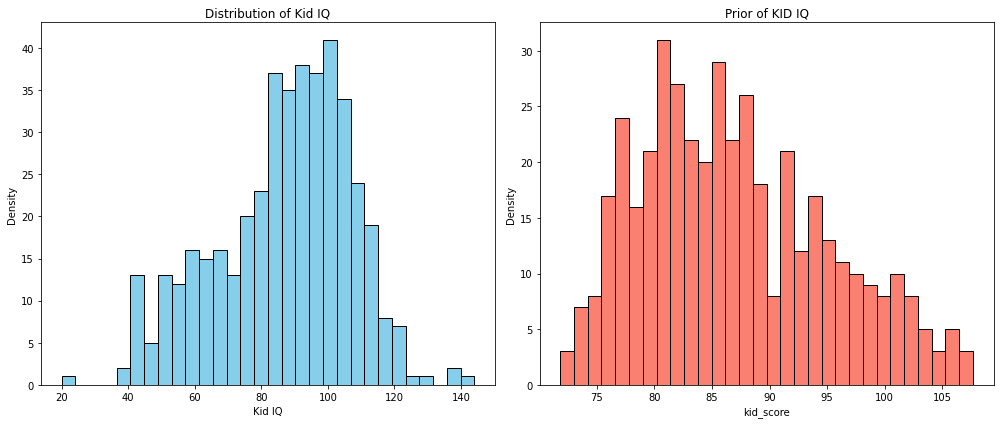

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

axs[0].hist(df.kid_score.values, bins=30, color='skyblue', edgecolor='black')
axs[0].set_title('Distribution of Kid IQ')
axs[0].set_xlabel('Kid IQ')
axs[0].set_ylabel('Density')

axs[1].hist(yields_pred_means, bins=30, color='salmon', edgecolor='black')
axs[1].set_title('Prior of KID IQ')
axs[1].set_xlabel('kid_score')
axs[1].set_ylabel('Density')

plt.tight_layout()
plt.show()